In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
#import torchvision
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

# Loading the Image Datasets

In [ ]:
from torchvision import transforms, datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR

Finding the mean and standard deviation values for my training set. However, this is for the method of normalising according to a mean and standard deviation value, which is not used in this instance.

The method I use for normalising resizes pixel values to the range [-1, 1].

In [ ]:
def calculate_mean_std(class_path, sample_size=100):
  channel_means = np.zeros(3)
  channel_stds = np.zeros(3)

  image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
  sampled_files = random.sample(image_files, min(sample_size, len(image_files)))

  for image_file in sampled_files:
    image_path = os.path.join(class_path, image_file)
    image = cv2.imread(image_path) / 255.0
    channel_means += np.mean(image, axis=(0, 1))
    channel_stds += np.std(image, axis=(0, 1))

  return channel_means, channel_stds

In [ ]:
import os
import random
import multiprocessing
def main():
  dataset_path = '/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/train'
  class_folders = os.listdir(dataset_path)

  num_processes = multiprocessing.cpu_count()
  pool = multiprocessing.Pool(num_processes)

  results = pool.map(calculate_mean_std, [os.path.join(dataset_path, class_folder) for class_folder in class_folders])

  pool.close()
  pool.join()

  total_means = np.sum([result[0] for result in results], axis=0)
  total_stds = np.sum([result[1] for result in results], axis=0)

  total_num_images = sum(len(os.listdir(os.path.join(dataset_path, class_folder))) for class_folder in class_folders)
  final_means = total_means / total_num_images
  final_stds = total_stds / total_num_images

  print("Mean values:", final_means)
  print("Standard deviation values:", final_stds)

In [ ]:
if __name__ == '__main__':
  main()

Mean values: [0.14841559 0.1634261  0.16317578]
Standard deviation values: [0.07476693 0.07425934 0.07857122]


In [ ]:
class SSDPreprocessTransform:
    def __init__(self, model_preprocess_function):
        self.model_preprocess_function = model_preprocess_function

    def __call__(self, img):
        # Convert image to a float tensor
        img_tensor = transforms.ToTensor()(img)

        # Apply the model's preprocessing function
        preprocessed_img = self.model_preprocess_function(img_tensor)
        return preprocessed_img

This function outputs the resized value:

In [ ]:
def ssd_preprocess(resized_inputs):
    return (2.0 / 255.0) * resized_inputs - 1.0

In [ ]:
ssd_transform = SSDPreprocessTransform(ssd_preprocess)

In [ ]:
resize_transform = transforms.Resize((320, 320))

In [ ]:
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

In [ ]:
#data_transform = transforms.Compose([
#    resize_transform,
#    transforms.ToTensor(),
#    transforms.Normalize(mean=NORM_MEAN,
#                         std=NORM_STD) # Apply SSD preprocessing
#])

In [ ]:
data_transform = transforms.Compose([
    resize_transform,
    ssd_transform,  # Apply SSD preprocessing
])

The amount of pictures in training and test sets:

In [ ]:
lengths = []
for folder in os.listdir('/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/train'):
  subfolder = os.path.join('/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/train', folder)
  lengths.append(len(os.listdir(subfolder)))
lengths
print('The amount of train images:', sum(lengths))

The amount of train images: 1956


In [ ]:
lengths = []
for folder in os.listdir('/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/test'):
  subfolder = os.path.join('/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/test', folder)
  lengths.append(len(os.listdir(subfolder)))
lengths
print('The amount of test images:', sum(lengths))

The amount of test images: 567


Loading the dataset:

In [ ]:
train_data_path = "/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/train"
test_data_path = "/content/drive/MyDrive/TOPDOWN_IMGCLASSIFICATION/test"

train_dataset = datasets.ImageFolder(root=train_data_path, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=data_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Checking the pre-processed data:

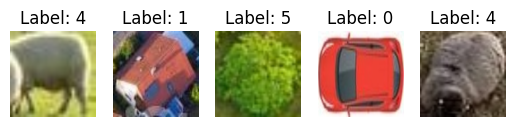

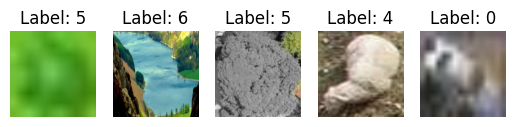

KeyboardInterrupt: ignored

In [ ]:
inverse_normalize = transforms.Normalize(
    mean=[-mean/std for mean, std in zip(NORM_MEAN, NORM_STD)],
    std=[1/std for std in NORM_STD]
)

for batch in train_loader:
    images, labels = batch
    # Apply inverse normalization
    images_inv = inverse_normalize(images)

    # Convert images to NumPy arrays for plotting
    images_np = images_inv.numpy()
    labels_np = labels.numpy()

    # Loop through the batch and plot each image
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.transpose(images_np[i], (1, 2, 0)))  # Convert from CHW to HWC
        plt.title(f"Label: {labels_np[i]}")
        plt.axis("off")

    plt.show()

In [ ]:
for batch in train_loader:
    images, labels = batch
    # Convert images to NumPy arrays for plotting
    images_np = images.numpy()
    labels_np = labels.numpy()

    # Loop through the batch and plot each image
    for i in range(5):
      plt.subplot(1, 5, i + 1)
      original_image = (images_np[i] + 1.0) * 255.0 / 2.0
      plt.imshow(np.transpose(original_image, (1, 2, 0)))# Convert from CHW to HWC
      plt.title(f"Label: {labels_np[i]}")
      plt.axis("off")

    plt.show()

The images are stored with labels in the DataLoader in 320 x 320 size:
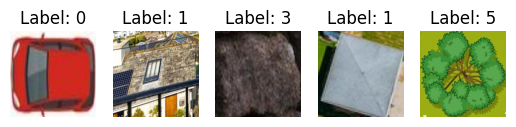

# Training the model

Now that I have pre-processed the data in a similar way to my obj detection pipeline, to be precise the pixel value normalisation stage, I can move on with training a MobileNet V2 pre-trained model, which is also used as the feature extractor in the obj detection pipeline.

(The values must be resized however, and 320 x 320 appears to be a good size for the model to at least recognise features well).

In [ ]:
# Load pre-trained MobileNetV2 model
num_classes = 7
model = models.mobilenet_v2(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 257MB/s]


In [ ]:
model.classifier = nn.Sequential(
    #nn.Dropout(0.2),
    nn.Linear(1280, num_classes)
)

In [ ]:
import torch.nn.functional as F
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define the learning rate scheduler (cosine annealing with warm-up)
#scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
#####ATTEMPT AT REPLICATING THE LOSS FUNCTION OF THE TENSORFLOW OBJECT DETECTION MODEL

#class WeightedSigmoidFocalLoss(nn.Module):
#    def __init__(self, alpha=1, gamma=2, weight=None, reduction='mean'):
#        super(WeightedSigmoidFocalLoss, self).__init__()
#        self.alpha = alpha
#        self.gamma = gamma
#        self.weight = weight
#        self.reduction = reduction

#    def forward(self, input, target):
#        p = torch.sigmoid(input)
#        ce_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
#        p_t = p * target + (1 - p) * (1 - target)
#        loss = ce_loss * ((1 - p_t) ** self.gamma)

#        if self.weight is not None:
#            loss *= self.alpha * target + (1 - self.alpha) * (1 - target)

#        if self.reduction == 'mean':
#            return loss.mean()
#        elif self.reduction == 'sum':
#            return loss.sum()
#        else:
#            return loss

In [ ]:
from torchvision import ops
#WSFcriterion = ops.sigmoid_focal_loss(alpha=0.25, gamma=2)

In [ ]:
num_epochs = 30

In [ ]:
# Initialize variables
best_metric = float('-inf')
epochs_since_improvement = 0
patience = 7

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        #loss = ops.sigmoid_focal_loss(outputs, targets, alpha = 0.25, gamma = 2)
        #loss = WSFcriterion(outputs, targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()

    # Validation after each epoch
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            val_loss += criterion(outputs, targets).item()
            #loss = ops.sigmoid_focal_loss(outputs, targets, alpha = 0.25, gamma = 2)
            #val_loss += WSFcriterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(test_loader):.4f}, Accuracy: {(100*correct/total):.2f}%")
    # Check if validation metric improved
    current_metric = (100*correct/total)
    if current_metric > best_metric:
        best_metric = current_metric
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
    # Check if early stopping criteria met
    if epochs_since_improvement >= patience:
        print(f"Early stopping: No improvement in {patience} epochs.")
        break

Epoch 1/30, Validation Loss: 0.4541, Accuracy: 83.77%
Epoch 2/30, Validation Loss: 0.4841, Accuracy: 83.25%
Epoch 3/30, Validation Loss: 0.5659, Accuracy: 77.25%
Epoch 4/30, Validation Loss: 0.4275, Accuracy: 84.66%
Epoch 5/30, Validation Loss: 0.3203, Accuracy: 89.42%
Epoch 6/30, Validation Loss: 0.3705, Accuracy: 86.07%
Epoch 7/30, Validation Loss: 0.3203, Accuracy: 87.83%
Epoch 8/30, Validation Loss: 0.3253, Accuracy: 87.83%
Epoch 9/30, Validation Loss: 0.3742, Accuracy: 86.77%
Epoch 10/30, Validation Loss: 0.3757, Accuracy: 86.07%
Epoch 11/30, Validation Loss: 0.3261, Accuracy: 88.01%
Epoch 12/30, Validation Loss: 0.3648, Accuracy: 87.13%
Early stopping: No improvement in 7 epochs.


# Saving and Loading the models

In [ ]:
import os

In [ ]:
directory_path = '/content/drive/MyDrive/IMGCLASSmodels/models'
if not os.path.exists(directory_path):
    # Create the directory
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")

Directory '/content/drive/MyDrive/IMGCLASSmodels/models/firsttry_mobilenetv2_model.pth' created.


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/IMGCLASSmodels/models/NORMVALUES_earlystopping_mobilenetv2_model.pth')

In [ ]:
#torch.save(model, '/content/drive/MyDrive/IMGCLASSmodels/models/SECONDSAVE_firsttry_mobilenetv2_model.pth')

In [ ]:
#model = torch.load('/content/drive/MyDrive/IMGCLASSmodels/models/earlystopping_mobilenetv2_model.pth')

In [ ]:
#model

In [ ]:
# Load the model in case of the CPU environment it was loaded in needing specifying
num_classes = 7
model = models.mobilenet_v2(pretrained=False)  # Set pretrained to False since you're loading your own weights
model.classifier = nn.Sequential(
    nn.Linear(1280, num_classes)
)  # Set pretrained to False since you'll load your own weights

# Load the saved state_dict into the model
checkpoint_path = '/content/drive/MyDrive/IMGCLASSmodels/models/earlystopping_mobilenetv2_model.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Patch functions


In [ ]:
# PyTorch Lightning
import os
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "/content/drive/MyDrive/IMGCLASSmodels/datasets"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/IMGCLASSmodels/patches"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Using device cuda:0


Placing the patch at a random location in an image:

In [ ]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [ ]:
#TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
#def patch_forward(patch):
#    # Map patch values from [-infty,infty] to ImageNet min and max
#    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
#    return patch

NameError: ignored

Normalising the patch's pixel values to the same range as the training and test images, to a range of [-1, 1]:

In [ ]:
#NORM_MEAN = np.array([0.485, 0.456, 0.406])
#NORM_STD = np.array([0.229, 0.224, 0.225])
#TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    #patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    patch = (2.0 / 255.0) * patch - 1.0
    return patch

Setting the validation metrics for the patch's ability to fool a model when placed on my test images:

In [ ]:
from tqdm.notebook import tqdm
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_3, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(test_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img #.to(device)
                img_labels = img_labels  #.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_3 += torch.logical_and((pred.topk(3, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_3/counter
    return acc, top5

In [ ]:
patch = torch.load('/content/drive/MyDrive/IMGCLASSmodels/patches/sheep_64_patch.pt')
eval_patch(model, patch, test_loader, label_names[4]['id'])

Validating...:   0%|          | 0/18 [00:00<?, ?it/s]

(tensor(0.9727), tensor(0.9987))

This function will be called with get_patches; it essentially calls all the previous functions to train the patch parameter to minimise the loss function, when the loss function measures the amount of correct predictions of the target class:

In [ ]:
def patch_attack(model, target_class, patch_size=32, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    #train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    #train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=0)
    #val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=0)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img #.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], dtype=torch.long).fill_(target_class)  #,device=pred.device
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top3 = eval_patch(model, patch, test_loader, target_class)

    return patch.data, {"acc": acc.item(), "top3": top3.item()}

This function, which although I personally don't use, is useful for saving the accuracy and top 3 appearances for the patch:

In [ ]:
import json
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Label map:

In [ ]:
label_names = [{'name':'car', 'id':1}, {'name':'house', 'id':2}, {'name':'person', 'id':3}, {'name':'rock', 'id':4}, {'name':'sheep', 'id':5}, {'name':'vegetation', 'id':6}, {'name':'water', 'id':7}]

In [ ]:
name = 'car'
label_names[2]['name']

'person'

This function get_patches is what we use to trigger the entire pipeline, which uses all the previous functions in the patch-making section.
I have to change the index number in the square brackets after 'label_names' to the location of the desired target class in the label map above:

In [ ]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            #c = label_names.index(name)
            #I have to change the index number in the square brackets after 'label_names' to the location of the desired target class in the label map above
            c = label_names[4]['id']
            file_name = os.path.join(CHECKPOINT_PATH, f"NORMVALUES{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            #else:
            #    patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            results = eval_patch(model, patch, test_loader, target_class=c)
            #if name in json_results:
            #    results = json_results[name][str(patch_size)]
            #else:
            #    results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

Make sure to un-hash the last two lines to get the patch.

In [ ]:
class_names = ['sheep']
patch_sizes = [32]

#patch_dict = get_patches(class_names, patch_sizes)
#save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

"person": {
        "64": [
            0.9841188788414001,
            1.0
<br>"person": {
        "32": [
            0.9654869654341219,
            0.9865392736112432
<br>Validation results for car and 32: {'acc': 0.8433544039726257, 'top3': 0.9883966445922852}
<br>Validation results for car and 64: {'acc': 0.9514768123626709, 'top3': 0.9973628520965576}
<br>Validation results for car and 100: {'acc': 0.9852320551872253, 'top3': 1.0}
<br>Validation results for sheep and 64: {'acc':0.9727, 'top3': 0.9987}
<br>Validation results for NORMcar and 32: {'acc': 0.8111814260482788, 'top3': 0.9926160573959351}
<br>Validation results for NORMsheep and 32: {'acc': 0.9127604365348816, 'top3': 0.9954426884651184}

The following cell was not necessary for my pipeline:

In [ ]:
def show_patches():
    # fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]

            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values

            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            # print(patch)
            # plt.figure(dpi=150)
            print(patch.shape)
            # patch = np.ascontiguousarray(patch.transpose(1,0,2))
            # np.reshape(patch, (64, 64))
            print(patch.shape)
            # img = im.fromarray(patch.astype('uint8'), 'RGB')
            plt.imsave(DATASET_PATH+"/"+str(p_idx)+str(psize)+cname+".png", patch, cmap='Greys')
            # data = im.fromarray(patch)

            # saving the final output
            # as a PNG file
            # img.save(DATASET_PATH+"/PIL_"+str(p_idx)+str(psize)+cname+".png")
            # plt.imshow(patch, interpolation='nearest')
            # plt.savefig(DATASET_PATH+"/MTPLTL_"+str(p_idx)+str(psize)+cname+".png")
            # ax[p_idx][c_idx].imshow(patch)
            # ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            # ax[p_idx][c_idx].axis('off')
    # fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # plt.show()
show_patches()

Load the patch as the .pt file, otherwise the file will not be recognised by the show_patches function:

In [ ]:
patch_dict = torch.load('/content/drive/MyDrive/IMGCLASSmodels/patches/sheep_64_patch.pt')
#patch_dict = open('/content/drive/MyDrive/IMGCLASSmodels/patches/patch_results.json')

Commented out all the '.device' code as I am working with a built-in CPU backend on Colab:

sheep 32 patch


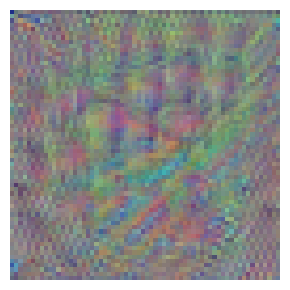

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*3, len(patch_sizes)*3))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            print(cname, psize, "patch")
            patch = patch_dict   #[cname][psize]["patch"].readlines()
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            #patch = (2.0 / 255.0) * patch - 1.0
            #patch = (patch + 1) / 2
            patch = patch.permute(1, 2, 0).numpy() ##.cpu()
            #patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax.imshow(patch, aspect='auto')   #[p_idx][c_idx]
            #ax.set_title(f"{cname}, size {psize}")   #[p_idx][c_idx]
            ax.axis('off')    #[p_idx][c_idx]
    #fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.tight_layout()
    plt.show()
show_patches()

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

# Extra

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = custom_loss(outputs, targets)
        loss.backward()
        optimizer.step()

In [ ]:
#class CustomClassifier(nn.Module):
#    def __init__(self, num_classes):
#        super(CustomClassifier, self).__init__()
#        self.avgpool = nn.AdaptiveAvgPool2d(1)
#        self.fc = nn.Linear(1280, num_classes)  # MobileNetV2's feature size is 1280
#
#    def forward(self, x):
#        x = self.avgpool(x)
#        x = torch.flatten(x, 1)
#        x = self.fc(x)
#        return x

In [ ]:
num_classes = 7 # my number of classes

In [ ]:
complete_model = nn.Sequential(
    features,
    CustomClassifier(num_classes)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
complete_model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m